In [1]:
%%time
# Import required libraries
%matplotlib inline

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

import re
import os
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200


from sklearn.preprocessing import OrdinalEncoder, StandardScaler

import datetime
print(datetime.datetime.now())

2019-03-29 05:34:09.085388
Wall time: 1.09 s


In [2]:
# Clean up data
good = 'Fully Paid'
bad = ['Charged Off', 'Default']
ignore = ['Current', 'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)']
# filter out columns that have over 85% of NaN
#df_2014 = pd.read_csv('../data/2014.csv')
#cols_to_keep=df_2014.columns[df_2014.isnull().sum()/df_2014.shape[0] < 0.85].tolist()
cols_to_keep=['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
              'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose',
              'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths',
              'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
              'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
              'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
              'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog',
              'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths',
              'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
              'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
              'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl','num_il_tl',
              'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
              'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort',
              'total_bc_limit', 'total_il_high_credit_limit', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']

# List of columns to drop that are not getting any value such as ID, URL or one that are duplicate
cols_to_drop = ['id', 'emp_title', 'pymnt_plan',  'url', 'fico_range_high','title', 'zip_code', 'mths_since_last_record', 'out_prncp_inv', 'total_pymnt', 
                'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 
                'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'out_prncp',
                'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'acc_now_delinq', 
                'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 
                'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 
                'mths_since_recent_revol_delinq', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag' ,'funded_amnt','funded_amnt_inv', 'initial_list_status']

def data_cleanup(df):
    df = df[cols_to_keep]
    df = df.loc[~df.loan_status.isin(ignore),]
    df = df.drop(columns=cols_to_drop)
    df.loan_status = df.loan_status.replace(bad,1)
    df.loan_status = df.loan_status.replace(good,0)
    df.mths_since_last_delinq= df.mths_since_last_delinq.fillna(999)
    df.term = df.term.apply(lambda x: re.search(r'\d\d', x).group()).astype(np.uint8)
    df.int_rate =  df.int_rate.str.replace('%','').astype(np.float32)
    df.revol_util =  df.revol_util.str.replace('%','').astype(np.float32)
    df.emp_length = df.emp_length.fillna(0).replace('[a-zA-Z+]*','',regex=True).replace('< 1',0,regex=True).astype(np.uint8)
    df.num_tl_120dpd_2m = df.num_tl_120dpd_2m.fillna(0)
    df.percent_bc_gt_75 = df.percent_bc_gt_75.fillna(0)
    df.revol_util = df.revol_util.fillna(0)
    # Get number of year of credit history at time of loan issue date
    df['earliest_cr_line_yrs'] = df.earliest_cr_line.apply(lambda x: 100-int(x[-2:]) if int(x[-2:]) > 18 else int(x[-2:])*-1 ) + df.issue_d.apply(lambda x: x[-2:]).astype(np.uint8)
    # Add a column for accounts in not satisfactory state
    df['num_un_sats']=df.open_acc - df.num_sats
    df.issue_d=pd.to_datetime(df.issue_d, format='%b-%y')
    df = df.drop(columns='earliest_cr_line')
    return df

    

In [3]:
%%time

# Loop through each data file and clean it up
data_files = ['../data/raw/{}'.format(i) for i in os.listdir('..\\data\\raw') if '201' in i]
df_all = pd.DataFrame()
for f in data_files:
    print("Proceessing: {}".format(f))
    temp_df = pd.read_csv(f)
    temp_df = data_cleanup(temp_df)
    df_all = pd.concat([df_all,temp_df])
    print("Processesed. Shape of df_all: {}".format(df_all.shape))
df_all = df_all.reset_index(drop=True)
df_all.fillna(df_all.median(), inplace=True)
df_all.to_csv('../data/processed/clean_data.csv', index=False)

Proceessing: ../data/raw/2012-13.csv


<string>:2: DtypeWarning: Columns (49,129,130,131,134,135,136,139) have mixed types. Specify dtype option on import or set low_memory=False.


Processesed. Shape of df_all: (181326, 49)
Proceessing: ../data/raw/2014.csv


<string>:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.


Processesed. Shape of df_all: (392092, 49)
Proceessing: ../data/raw/2015.csv


<string>:2: DtypeWarning: Columns (19,59) have mixed types. Specify dtype option on import or set low_memory=False.


Processesed. Shape of df_all: (637749, 49)
Proceessing: ../data/raw/2016.csv
Processesed. Shape of df_all: (795091, 49)
Proceessing: ../data/raw/2017.csv


<string>:2: DtypeWarning: Columns (118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.


Processesed. Shape of df_all: (841160, 49)
Wall time: 1min 6s


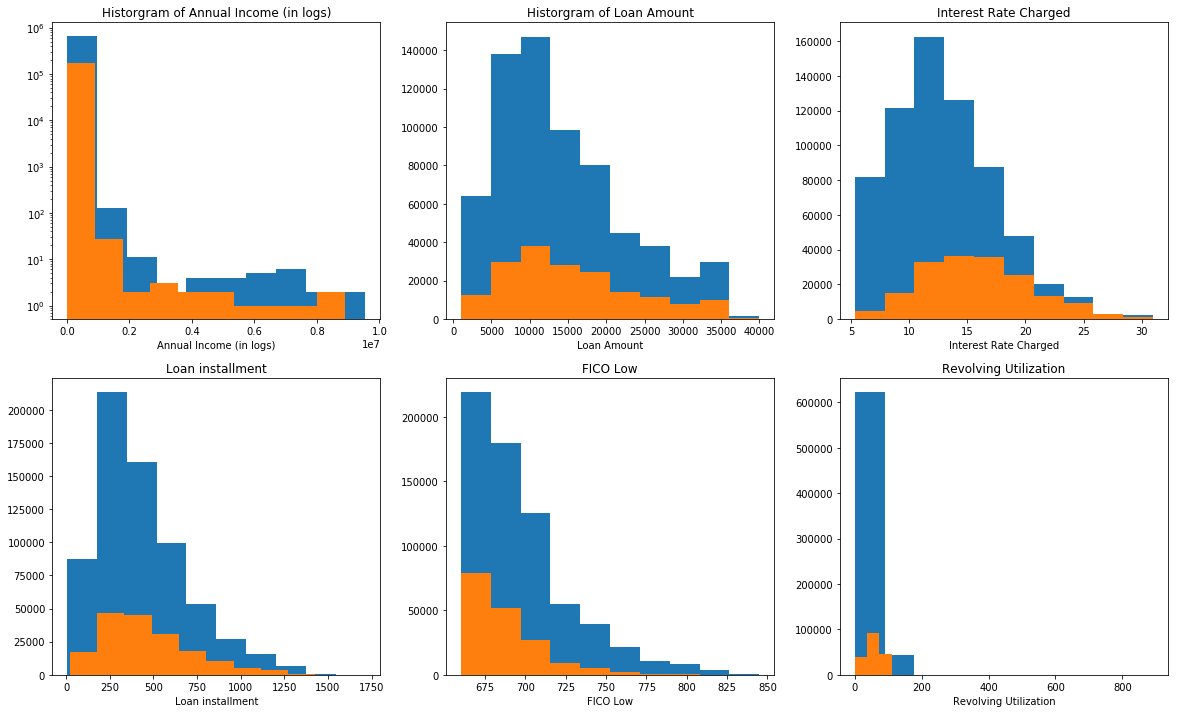

In [4]:
#fig, ax = plt.subplots(2,2, figsize=(20,20))
#sns.distplot(np.log(df_all.annual_inc))
plt.figure(figsize=(20,12))

plt.subplot(2,3,1)
plt.hist(df_all.annual_inc[df_all.loan_status == 0], log=True)
plt.hist(df_all.annual_inc[df_all.loan_status == 1], log=True)

plt.xlabel("Annual Income (in logs)")
plt.title("Historgram of Annual Income (in logs)")

plt.subplot(2,3,2)
plt.hist(df_all.loan_amnt[df_all.loan_status == 0])
plt.hist(df_all.loan_amnt[df_all.loan_status == 1])

plt.xlabel("Loan Amount")
plt.title("Historgram of Loan Amount")

plt.subplot(2,3,3)
plt.hist(df_all.int_rate[df_all.loan_status == 0])
plt.hist(df_all.int_rate[df_all.loan_status == 1])
plt.xlabel("Interest Rate Charged")
plt.title("Interest Rate Charged")

plt.subplot(2,3,4)
plt.hist(df_all.installment[df_all.loan_status == 0])
plt.hist(df_all.installment[df_all.loan_status == 1])
plt.xlabel("Loan installment")
plt.title("Loan installment")


plt.subplot(2,3,5)
plt.hist(df_all.fico_range_low[df_all.loan_status == 0])
plt.hist(df_all.fico_range_low[df_all.loan_status == 1])
plt.xlabel("FICO Low")
plt.title("FICO Low")

plt.subplot(2,3,6)
plt.hist(df_all.revol_util[df_all.loan_status == 0])
plt.hist(df_all.revol_util[df_all.loan_status == 1])
plt.xlabel("Revolving Utilization")
plt.title("Revolving Utilization")

plt.show()

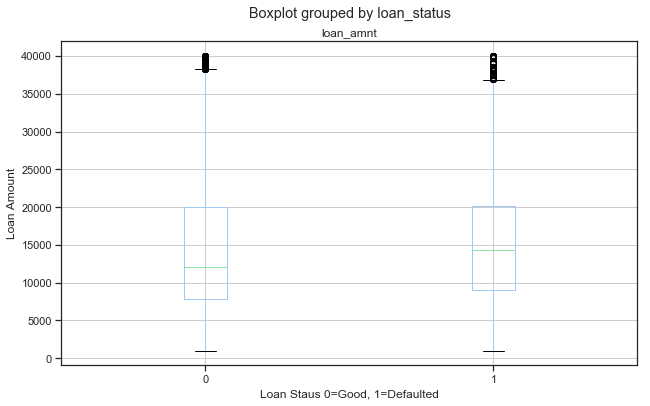

In [34]:
df_all.boxplot('loan_amnt', 'loan_status', figsize=(10,6))#, showfliers=False)
_ = plt.xlabel("Loan Staus 0=Good, 1=Defaulted")
_ = plt.ylabel("Loan Amount")

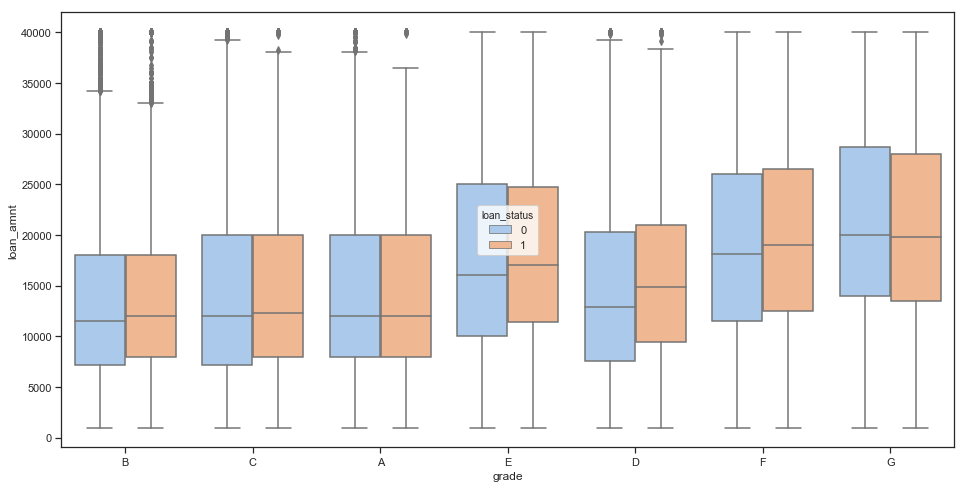

In [53]:
plt.figure(figsize=(16,8))
sns.boxplot(y='loan_amnt',x='grade', hue='loan_status',data=df_all)

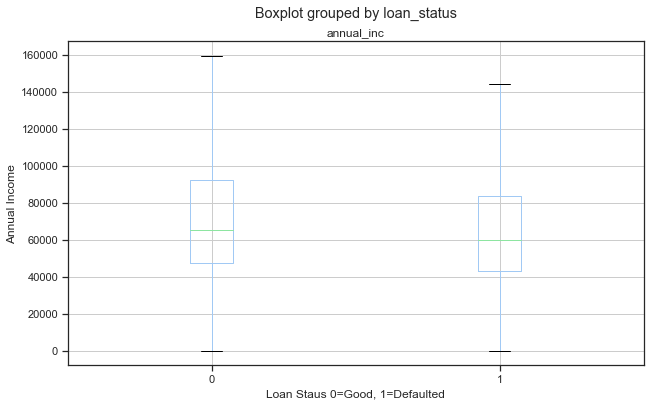

In [37]:
_ = df_all.boxplot('annual_inc', 'loan_status', figsize=(10,6), showfliers=False)
_ = plt.xlabel("Loan Staus 0=Good, 1=Defaulted")
_ = plt.ylabel("Annual Income")

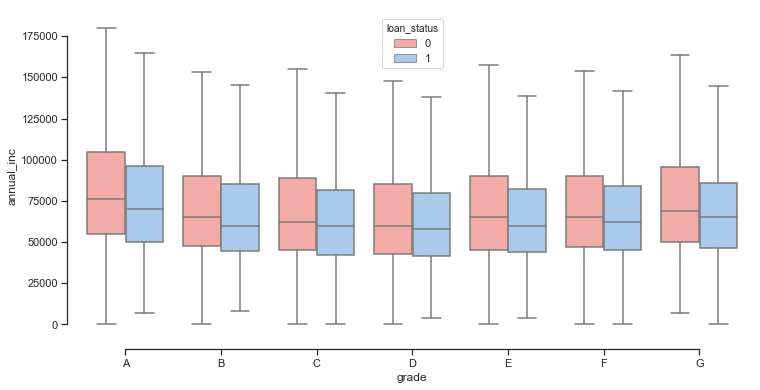

In [38]:
plt.figure(figsize=(12,6))
sns.set(style="ticks", palette="pastel")

sns.boxplot(x='grade', y='annual_inc',hue='loan_status', palette=['r','b'], data=df_all.sort_values(by='grade'), showfliers=False)
sns.despine(offset=10, trim=True)

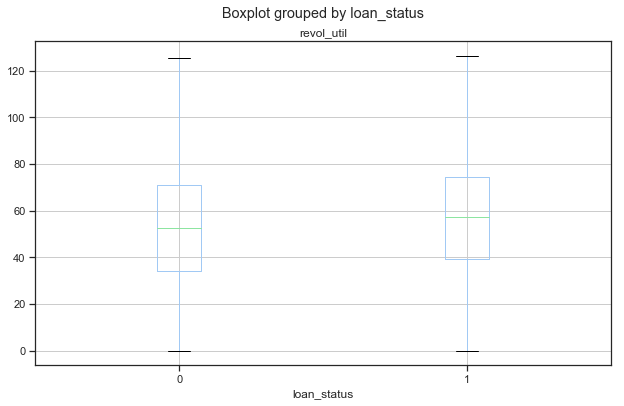

In [8]:
_ = df_all.boxplot('revol_util', 'loan_status', figsize=(10,6), showfliers=False)

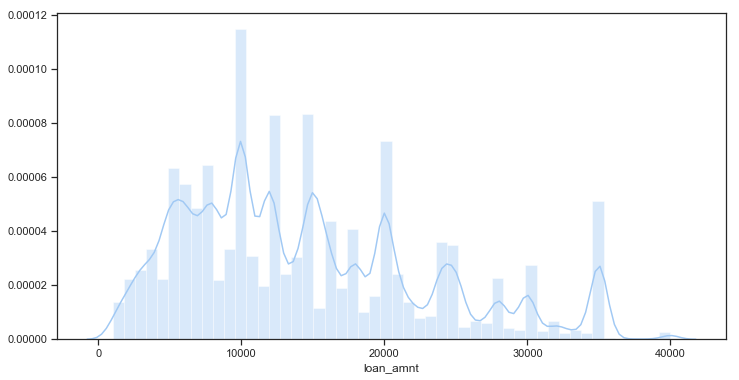

In [9]:
plt.figure(figsize=(12,6))
_ = sns.distplot(df_all.loan_amnt)

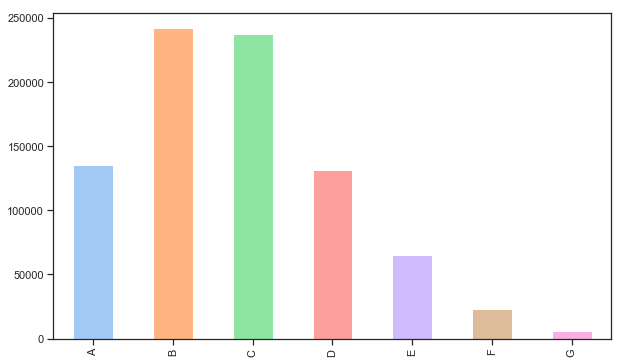

In [10]:
_=df_all.grade.value_counts().sort_index().plot.bar(figsize=(10,6))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

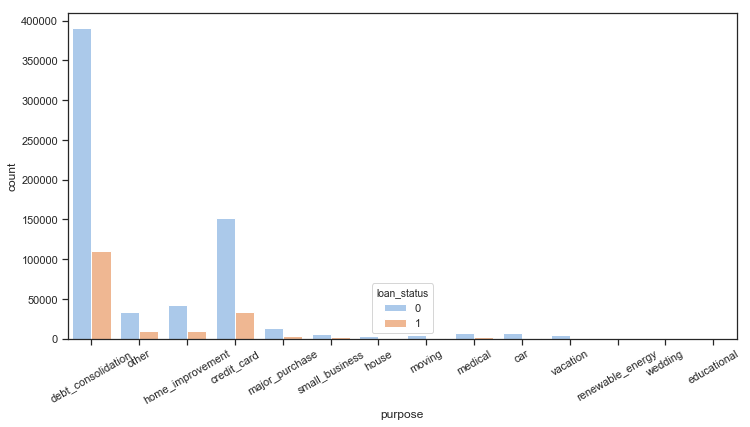

In [62]:
plt.figure(figsize=(12,6))
sns.countplot(x='purpose', hue='loan_status', data=df_all)
plt.xticks(rotation=30)


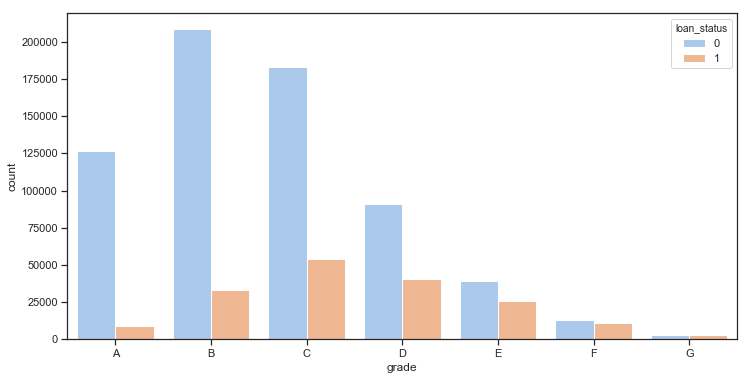

In [39]:
plt.figure(figsize=(12,6))
sns.countplot( x='grade', hue='loan_status', data=df_all.sort_values(by='grade'))

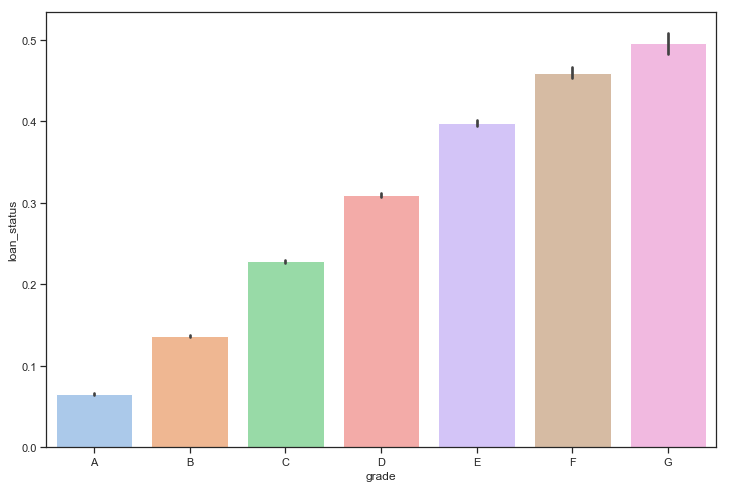

In [40]:
plt.figure(figsize=(12,8))
sns.barplot(x='grade',y='loan_status',data=df_all.sort_values(by='grade'))

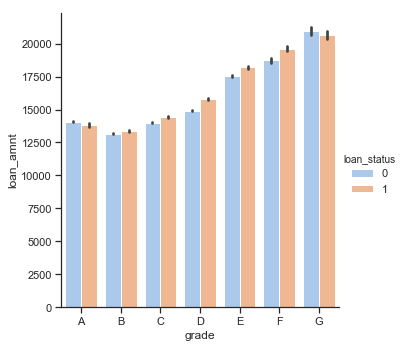

In [41]:
sns.catplot(x='grade', y='loan_amnt', hue='loan_status', data=df_all.sort_values(by='grade'), kind='bar')

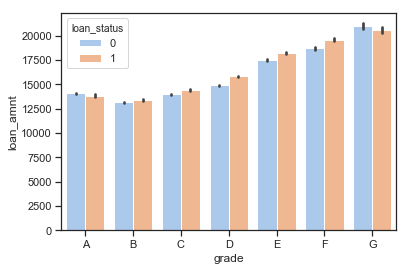

In [42]:
sns.barplot(x='grade', y='loan_amnt', hue='loan_status', data=df_all.sort_values(by='grade'))

In [16]:
corr=df_all.corr()

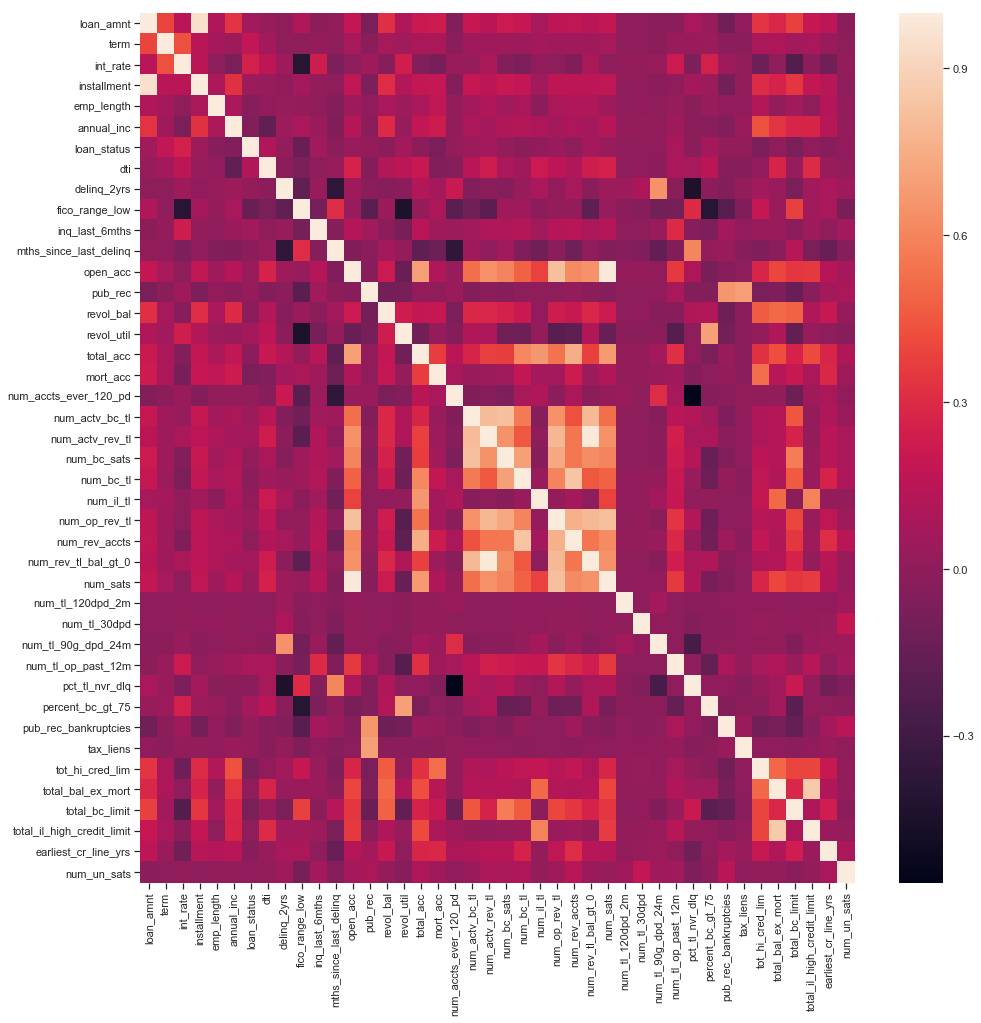

In [17]:
plt.figure(figsize=(16,16))
sns.heatmap(corr)

In [18]:
#highly co-relagted pairs
# loan_amnt - installment
# num_sats - open_acc

In [19]:
pd.concat([df_all[['num_sats', 'open_acc', 'loan_status']], df_all.num_sats - df_all.open_acc], axis=1)

#df_all.num_sats - df_all.open_acc

,num_sats,open_acc,loan_status,0
0,6.0,6,0,0.0
1,16.0,16,0,0.0
2,8.0,8,0,0.0
3,9.0,9,0,0.0
4,29.0,29,0,0.0
5,14.0,14,0,0.0
6,12.0,12,0,0.0
7,5.0,5,0,0.0
8,7.0,7,0,0.0
9,4.0,4,0,0.0


In [20]:
pd.concat([df_all[['loan_amnt', 'installment', 'annual_inc', 'dti', 'loan_status']],df_all.loan_amnt/df_all.annual_inc], axis=1)

,loan_amnt,installment,annual_inc,dti,loan_status,0
0,14000,470.71,88000.00,10.02,0,0.159091
1,15000,516.10,98000.00,6.15,0,0.153061
2,15000,476.30,63000.00,16.51,0,0.238095
3,10000,321.13,102000.00,15.55,0,0.098039
4,20800,706.16,81500.00,16.73,0,0.255215
5,27050,885.46,55000.00,22.87,0,0.491818
6,9750,333.14,26000.00,25.12,0,0.375000
7,3000,100.87,25000.00,24.68,0,0.120000
8,12000,407.40,40000.00,16.94,0,0.300000
9,7550,266.34,28000.00,8.40,0,0.269643


### Observation
- majority of time loan is capped to 50% of annual income with upper limit of 40K
- big cluster of detault are within 25-35K of loan amount

Wall time: 2.61 s


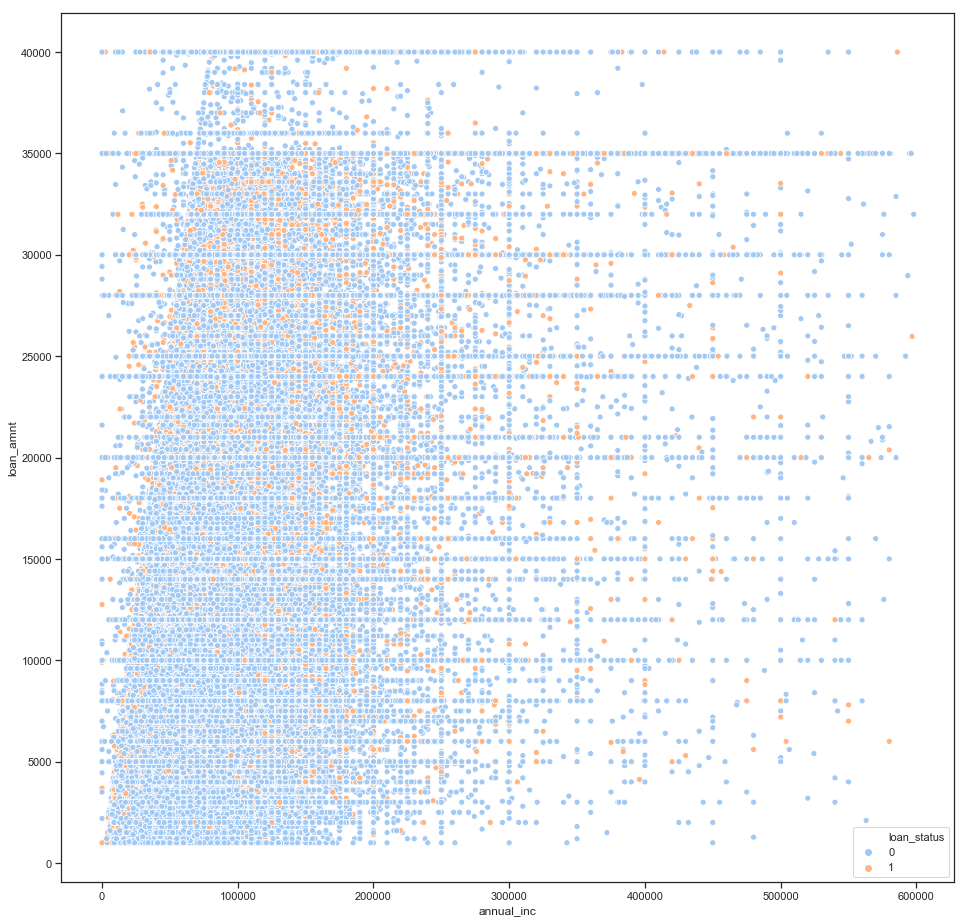

In [21]:
%%time
plt.figure(figsize=(16,16))
sns.scatterplot(df_all[df_all.annual_inc < 600000]['annual_inc'], df_all[df_all.annual_inc < 600000]['loan_amnt'], hue=df_all.loan_status)


Wall time: 2.59 s


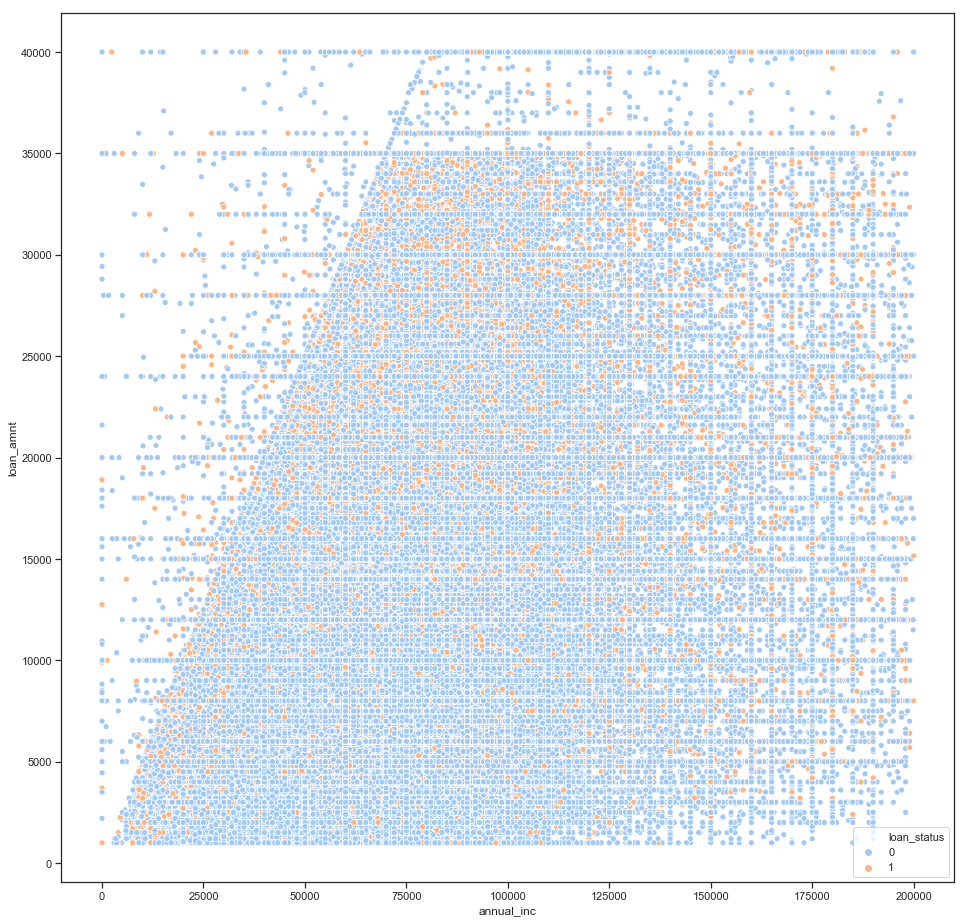

In [22]:
%%time
plt.figure(figsize=(16,16))
sns.scatterplot(df_all[df_all.annual_inc < 200000]['annual_inc'], df_all[df_all.annual_inc < 200000]['loan_amnt'], hue=df_all.loan_status)

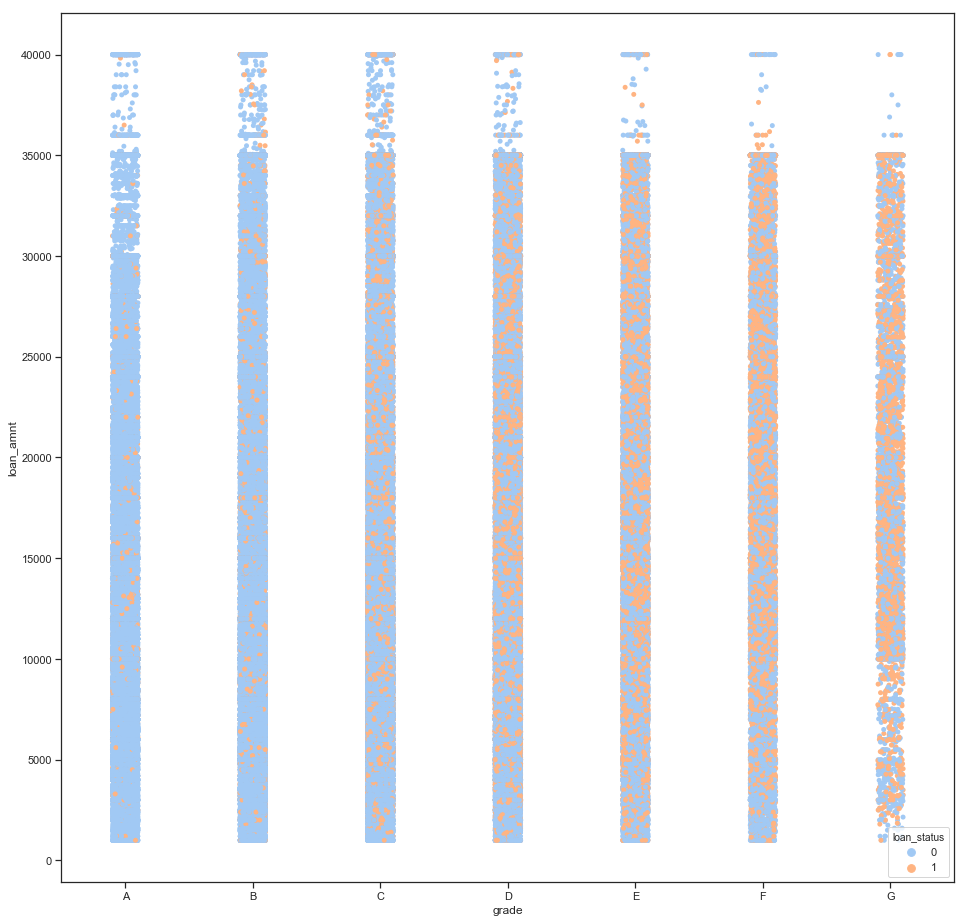

In [63]:
plt.figure(figsize=(16,16))
#sns.set(style="ticks")
ax=plt.subplot(111)
sns.catplot(x='grade', y='loan_amnt',hue='loan_status',row_order=['A','B','C','D','E','F','G'], data=df_all.sort_values(by='grade'), ax=ax)
plt.close(2)
plt.show()

In [24]:
df_all.select_dtypes(include='object').head()

,grade,sub_grade,home_ownership,verification_status,purpose,addr_state
0,B,B4,RENT,Not Verified,debt_consolidation,NC
1,C,C2,RENT,Not Verified,debt_consolidation,NY
2,A,A5,MORTGAGE,Not Verified,debt_consolidation,FL
3,B,B1,MORTGAGE,Not Verified,debt_consolidation,MA
4,B,B5,RENT,Verified,debt_consolidation,NY


In [25]:
def data_preprocess(df):
    numerical_attr = [i for i in df.select_dtypes(exclude=['datetime64','object']).columns if i not in ['loan_status']]
    scaler=StandardScaler()
    scaler.fit(df[numerical_attr])
    df_num=pd.DataFrame(scaler.transform(df[numerical_attr]), index=df[numerical_attr].index, columns=df[numerical_attr].columns)
    df_num['loan_status']=df['loan_status']
    
    cat_att= [i for i in df.select_dtypes(include=['object']).columns ]
    cat_enc = OrdinalEncoder()
    cat_enc.fit(df[['grade', 'sub_grade']])
    df[['grade', 'sub_grade']]=pd.DataFrame(cat_enc.transform(df[['grade', 'sub_grade']]))
    df_cat = pd.get_dummies(df[cat_att])
    df = pd.concat([df_num,df_cat],axis=1)
    return df

In [26]:
df_all_process = df_all.copy()
df_all_process = data_preprocess(df_all_process)
cols=[i for i in df_all_process.columns if i not in 'loan_status']
cols.insert(0,'loan_status')
df_all_process = df_all_process[cols]

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, float32, int64, float64 were all converted to float64 by StandardScaler.
  """


In [27]:
df_all_process.to_csv('../data/processed/data_for_modeling.csv', index=False)

In [28]:
print(datetime.datetime.now())

2019-03-29 05:40:00.198977
